In [1]:
## Bring in needed mods
import pandas as pd, numpy as np, glob
from matplotlib import pyplot as plt
%matplotlib inline

In [178]:
## Set relative regions of MAT locus
MAT = [1529240,1661861]

In [2]:
## Define ftn for loading dataframes
def makedf(paths,sep='_',fn = 1):
    df = []
    for d in paths:
        
        temp = pd.read_csv(d,index_col=0)
        temp['Chrom'] = int(d.split(sep)[fn])
        temp['Oldix'] = temp.index
        df.append(temp)
        
    return pd.concat(df).reset_index(drop=True)

## Load in chromosome map
chrommap = pd.read_csv('/home/croth/Downloads/B3502/DATA/chrommap.csv.gz')
chrommap['Seqid'] = chrommap.Contig
chrommap.drop('Contig',axis=1,inplace=True)

## Load in centormere locs
centlocs = pd.read_csv('/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv',
                      index_col=0)

## Merge dataframes
chrommap['Chromosome'] = chrommap.index+1
chrommap = chrommap.merge(centlocs)
chrommap.head()

,Length,Cumlen,Midpts,Seqid,Chromosome,Left,Right
0,2300533,0,1150266.5,AE017341.1,1,942544,993056
1,1632307,2300533,3116686.5,AE017342.1,2,860449,900038
2,2105742,3932840,4985711.0,AE017343.1,3,806551,906800
3,1783081,6038582,6930122.5,AE017344.1,4,222000,273992
4,1507550,7821663,8575438.0,AE017345.1,5,784047,849321


In [3]:
## Gather paths
gtpaths = sorted(glob.glob('../GENOTYPE/GT/AE017*.1.B3502.progeny_*_genotypes.csv.gz'))
dppaths = sorted(glob.glob('../GENOTYPE/DP/AE017*.1.B3502.progeny_*_depths.csv.gz'))
arpaths = sorted(glob.glob('../GENOTYPE/AF/AE017*.1.B3502.progeny_*_allele_ratios.csv.gz'))
inpaths = sorted(glob.glob('../GENOTYPE/INFO/AE017*.1.B3502.progeny_*_info_cols.csv.gz'))

In [4]:
## Make dataframes
genos = makedf(gtpaths)
depth = makedf(dppaths)
ratio = makedf(arpaths)
infos = makedf(inpaths)

In [5]:
## Take progeny sample name
samples = sorted([s for s in genos.columns if s[0] in ['A','B']])
len(samples)

57

In [22]:
invar = genos[(genos[samples].T.sum() == 0)].index.tolist()

In [23]:
## Load in parent variants
parentvcf = pd.read_csv('../GENOTYPE/B3502_stock_variants.csv.gz',
                       index_col=0)
parentvcf.head()

,Seqid,Pos,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix,B3502_A1,B3502_B1,B3502_B7,CF830,Oldgeneix
2935,AE017341.1,530127,15706.400,1.0,1,C.G,1,1,2120,snp,1,2935,0.0,0.0,0.0,1.0,2935
4644,AE017341.1,884619,11033.600,1.0,1,G.A,1,1,790,snp,1,4644,1.0,1.0,1.0,0.0,4644
5261,AE017341.1,1032506,11176.400,1.0,1,T.C,1,1,1121,snp,1,5261,1.0,1.0,1.0,0.0,5261
7282,AE017341.1,1430787,495.554,1.0,1,G.T,1,1,595,snp,1,7282,0.0,1.0,0.0,0.0,7282
8773,AE017341.1,1694543,36510.300,1.0,1,G.C,1,1,1639,snp,1,8773,1.0,1.0,1.0,0.0,8773


In [24]:
genosdf = pd.concat([genos[samples],infos],axis=1)
genosdf = genosdf[(~genosdf.index.isin(invar))]
genosdf.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,Qual,Callrate,Nallele,Alleles,Maxlen,Minlen,Depth,Type,Chrom,Oldix
588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185.086,1.0,1,AGACCCCCCCCCCCCCATGT.AGACCCCCCCCCCCCATGT,19,19,2354,del,1,588
945,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,46343.900,1.0,4,CGTTGGTTT.CGTTGTTTT.GGTTTTTTT.GGTTGTTTT.GGTTGTTT,9,9,2960,snp,1,945
3381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,4256.090,1.0,3,ATGTTTTTTTTTTTTTTTTTTATGGCC.TTTTTTTTTTTTTTTTTT...,27,27,3387,complex,1,3381
7550,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,3994.430,1.0,1,G.C,1,1,7668,snp,1,7550
7551,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4283770.000,1.0,1,G.C,1,1,152698,snp,1,7551


In [143]:
not_in_parent = []
not_in_sample = []
samp_in_parent = []

for i,c in chrommap.iterrows():
    chrom = c.Chromosome
    ptemp = parentvcf[(parentvcf.Chrom==chrom)]
    stemp = genosdf[(genosdf.Chrom==chrom)]
    
    
    stemppos = [np.arange(*a) 
                for a in zip((stemp.Pos-stemp.Maxlen).values,
                (stemp.Pos+stemp.Maxlen).values)]
    
    kpos = np.concatenate([[j for j,i in enumerate(stemppos) if np.max(i == p)] 
                              for p in ptemp.Pos.values])
    
    sip = stemp.iloc[kpos][['Pos']].index
    samp_in_parent.append(sip)
    
sam_in_parent_ix = np.concatenate(samp_in_parent)

In [146]:
len(np.unique(sam_in_parent_ix))

2148

In [151]:
l,c = np.unique(sam_in_parent_ix,return_counts=True)

In [159]:
genosdf.loc[l,:].shape, parentvcf.shape

((2148, 69), (2155, 17))

In [166]:
missing = []
for i,c in chrommap.iterrows():
    chrom = c.Chromosome
    ptemp = parentvcf[(parentvcf.Chrom==chrom)]
    stemp = genosdf[(genosdf.Chrom==chrom) & (genosdf.index.isin(l))]
    
    for a in ptemp[~(ptemp.isin(stemp.index))].Pos:
        missing.append((chrom,a))
        
len(missing)

2155

In [175]:
genosdf['AF'] = np.sum(genosdf[samples] == 0,axis=1)/len(samples)

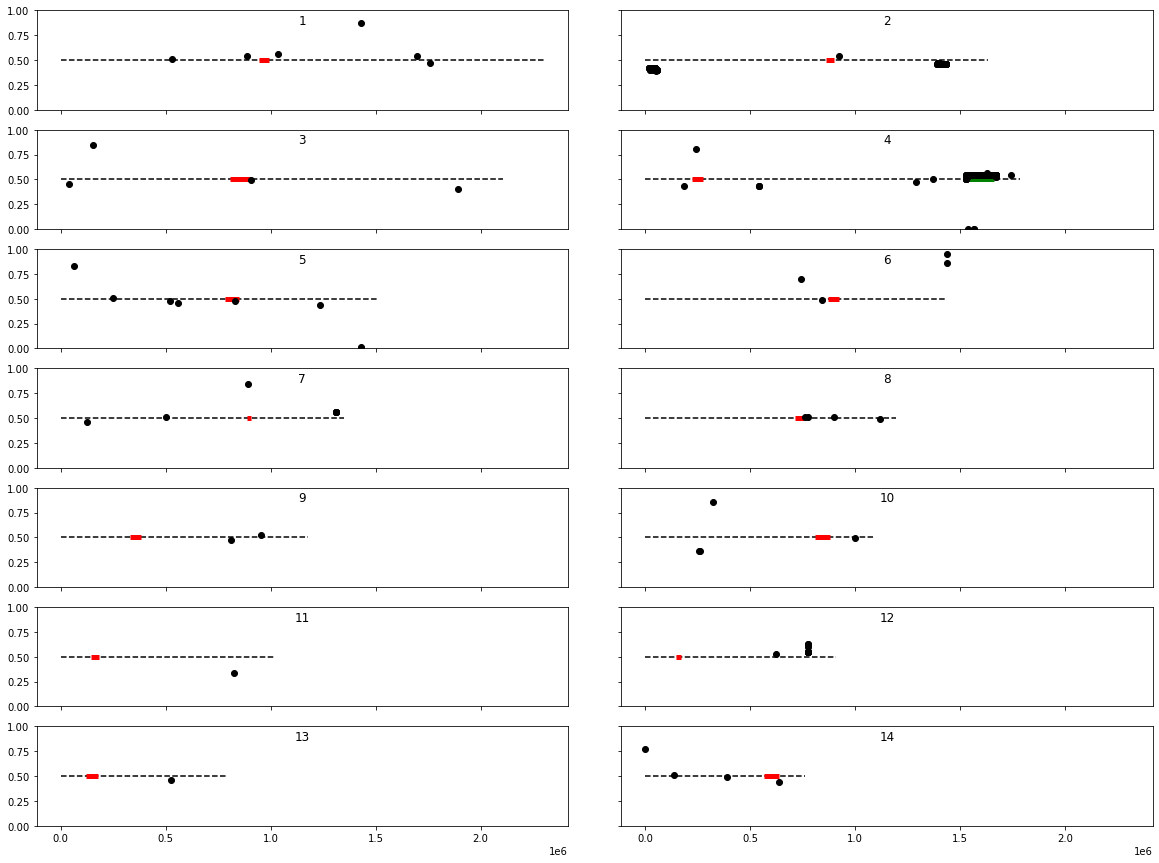

In [179]:
fig,ax = plt.subplots(7,2,figsize=(20,15),sharex=True,sharey=True)

for i,(j,c) in enumerate(chrommap.iterrows()):
    
    plt.sca(ax.ravel()[i])
    plt.hlines(0.5,0,c.Length,color='k',linestyle='--')
    
    plt.hlines(0.5,c.Left,c.Right,color='r',linewidth=5)
    
    temp = genosdf[(genosdf.index.isin(l)) & 
                   (genosdf.Chrom==c.Chromosome)]
    
    
    plt.plot(temp.Pos,temp.AF,'ko')
    plt.title(i+1,y=.8)
    
plt.sca(ax.ravel()[3])
plt.hlines(0.5,*MAT,color='g',linewidth=5)

plt.ylim(0,1)
plt.subplots_adjust(wspace=0.1);